In [4]:
%matplotlib inline
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 7)

popular_climbs = (
    pd.read_csv('data/popular_climbs.csv')
    .assign(Route=lambda x:x['Route'].replace('Fuhrers Finger', "Fuhrer's Finger"))
)

# Understanding Aggregations
---

Data aggregation is a powerful tool that allows one to understand a population via summarization; changing the granularity of data from individual observations to groups of observations can make patterns suddenly clear.

* Computing distributions is an example.
* descriptions grouped by labels, instead of individuals.

## Reshaping Data: Pivot Tables

Pivot tables are compact ways of summarizing groups within data. The pivot refers to *reshaping* a table from a long table of rows indexed by two characteristics, to a wide table with one characteristic per axis. 

As a simple example, consider a table of aggregate student records resulting from a groupby operation; each record contains the GPA of all members of one year's student body for a given department:

|Year|Course Dept|Avg Grade|
|---|---|---|
|Senior|CS|3.3|
|Senior|Math|2.9|
|Senior|DS|3.1|
|Junior|CS|3.4|
|Junior|Math|3.0|
|Junior|DS|3.0|
|Sophomore|CS|3.0|
|Sophomore|Math|3.1|
|Sophomore|DS|2.9|
|Freshman|CS|3.2|
|Freshman|Math|3.2|
|Freshman|DS|3.2|
|...|...|...|

While this table is easy to work with, drawing quick comparisons across attributes is cumbersome. A pivot table created from these averages involves reshaping the long table to a wider, more compact, format. In this case:
* the index of the pivot table contains the unique values of 'Course Dept',
* the columns of the pivot table contains the unique values of 'Year',
* The values of the pivot table contains the values of 'Avg Grade'

The pivot table:

|---|Freshman|Sophomore|Junior|Senior|
|---|---|---|---|---|
|CS|3.2|3.0|3.4|3.3|
|Math|3.2|3.1|3.0|2.9|
|DS|3.2|2.9|3.0|3.1|
|...|...|...|...|...|

In Pandas, such a reshaping is done with the `pivot` method.

*Remarks:*
* In the pivot table one can easily spot the trend that, as students progress, math classes get harder, while CS classes get easier. 
* The 'Year' values were set as the columns of the pivot table, as there are only 4 distinct values; there may be many departments.
* The pivot is merely a *reshaping* of the original table; the number of entries in the pivot is the same as the number of rows in the original table.

**Example:** Recall the dataset consisting of attempts to summit Mt. Rainier. Even among just the 10 most popular climbing routes, listing the number of climbers who attempted each route on every given day results in a long table with 895 rows. Such a table is hard to manually inspect!

In [5]:
climbers_by_route_day = popular_climbs.groupby(['Date', 'Route'])['Attempted'].sum().reset_index()
climbers_by_route_day

,Date,Route,Attempted
0,1/16/2014,Little Tahoma,2
1,1/18/2014,Gibraltar Ledges,8
2,1/19/2014,Gibraltar Ledges,2
...,...,...,...
892,9/8/2015,Disappointment Cleaver,2
893,9/9/2014,Disappointment Cleaver,29
894,9/9/2015,Disappointment Cleaver,16


The pivot table present the attempts by day and route in a matrix:

In [6]:
climbers_by_route_day.pivot(index='Date', columns='Route', values='Attempted')

Route,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,Gibraltar Ledges,Ingraham Direct,Kautz Glacier,Liberty Ridge,Little Tahoma,Ptarmigan Ridge
Date,,,,,,,,,
1/16/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1/18/2014,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
1/19/2014,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9/8/2015,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9/9/2014,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9/9/2015,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In this pivot table, the entries with `NaN` values correspond to day where a climbing route had no one attempt it; filling in the `NaN` entries with zero in this case makes sense (this is *not* always the case, however!).

The pattern of performing a `groupby` operation followed by a reshaping operation is so common, Pandas provides a method that combines the two. 

The `pivot_table` DataFrame method is like `pivot` with an additional keyword argument `aggfunc` that applies the provided function on the groups defined by the columns specified by the `index`/`column` arguments:

In [7]:
popular_climbs.pivot_table(
    index='Date', 
    columns='Route', 
    values='Attempted', 
    aggfunc='sum',
    fill_value=0
)

Route,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,Gibraltar Ledges,Ingraham Direct,Kautz Glacier,Liberty Ridge,Little Tahoma,Ptarmigan Ridge
Date,,,,,,,,,
1/16/2014,0,0,0,0,0,0,0,2,0
1/18/2014,0,0,0,8,0,0,0,0,0
1/19/2014,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9/8/2015,2,0,0,0,0,0,0,0,0
9/9/2014,29,0,0,0,0,0,0,0,0
9/9/2015,16,0,0,0,0,0,0,0,0


*Remark:* The `pivot_table` is equivalent to `pivot` when the aggregation function is the identity function (`aggfunc=lambda x:x`).

### Conditional distributions are pivot tables

**Example:** To understand where and when most *individual climbers* are on Mt. Rainier, compute
1. the distribution of Routes that climber's use to attempt to summit the mountain,
1. the distribution of months of the year when climbers attempt to summit the mountain,
1. the conditional distribution of routes climbed by month of the year. 

Note that this is *not* asking for the distribution of routes used by climbing parties (which corresponds to a row of the dataframe), but rather the distribution of routes used by climbers.

Before calculating the desired distributions, the month of the year must be stripped from the 'Date' attribute:

In [8]:
popular_climbs_with_month = popular_climbs.assign(Month=popular_climbs['Date'].str.split('/').str[0].astype(int))

The distribution of routes used by climbers is computed by calculating the total number of climbers that attempted each route up the mountain, then normalizing each sum by the total number of climbers:

In [9]:
climbers_by_route = popular_climbs_with_month.groupby('Route')['Attempted'].sum()
climbers_by_route_distr = climbers_by_route / climbers_by_route.sum()
climbers_by_route_distr

Route
Disappointment Cleaver    0.745837
Emmons-Winthrop           0.148707
Fuhrer's Finger           0.013372
                            ...   
Liberty Ridge             0.008082
Little Tahoma             0.014498
Ptarmigan Ridge           0.002792
Name: Attempted, Length: 9, dtype: float64

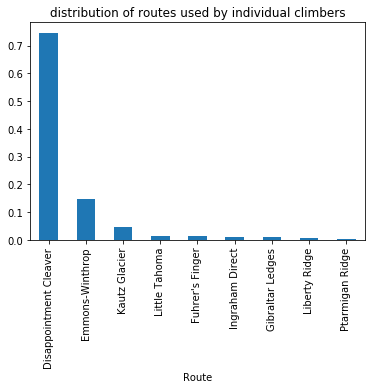

In [10]:
(
    climbers_by_route_distr
    .sort_values(ascending=False)
    .plot(kind='bar', title='distribution of routes used by individual climbers')
);

Notice that two of the routes on the mountain account for almost 90% of the climbers on the mountain during that time! Similarly, the distribution of months in which individual climbers attempted to summit Mt. Rainier is calculated by:

In [11]:
climbers_by_month = popular_climbs_with_month.groupby('Month')['Attempted'].sum().sort_index()
climbers_by_month_distr = climbers_by_month / climbers_by_month.sum()
climbers_by_month_distr

Month
1     0.005192
2     0.003967
3     0.007494
        ...   
10    0.001567
11    0.000245
12    0.000147
Name: Attempted, Length: 12, dtype: float64

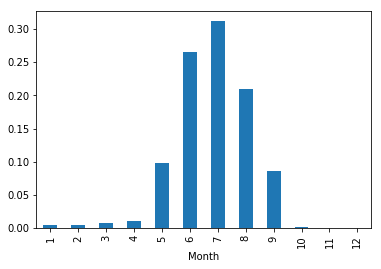

In [12]:
climbers_by_month_distr.plot(kind='bar');

Most climbers attempt to summit Rainier during the summer months of June, July, and August.

To compute the conditional distribution, calculate the total number of climbers that attempted a route in a given month, then normalize by the total number of climbers. This gives the proportion of climbing activity that occurs in a given time and place on the mountain. 

First, calculate the sums -- recall that `pivot_table` performs the `groupby`!

In [13]:
climbers_by_month_route = (
    popular_climbs_with_month
    .pivot_table(index='Month', columns='Route', values='Attempted', aggfunc='sum', fill_value=0)
)

climbers_by_month_route

Route,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,Gibraltar Ledges,Ingraham Direct,Kautz Glacier,Liberty Ridge,Little Tahoma,Ptarmigan Ridge
Month,,,,,,,,,
1,20,0,5,56,21,0,0,4,0
2,23,0,4,36,16,0,0,2,0
3,60,0,7,19,62,0,0,5,0
...,...,...,...,...,...,...,...,...,...
10,20,0,0,0,0,4,0,8,0
11,5,0,0,0,0,0,0,0,0
12,0,0,0,3,0,0,0,0,0


Then normalize by the total number of climbers:

In [14]:
total_climbers = climbers_by_month_route.sum().sum()

climbers_by_month_route_distr = climbers_by_month_route / total_climbers
climbers_by_month_route_distr

Route,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,Gibraltar Ledges,Ingraham Direct,Kautz Glacier,Liberty Ridge,Little Tahoma,Ptarmigan Ridge
Month,,,,,,,,,
1,0.000980,0.0,0.000245,0.002743,0.001029,0.000000,0.0,0.000196,0.0
2,0.001127,0.0,0.000196,0.001763,0.000784,0.000000,0.0,0.000098,0.0
3,0.002939,0.0,0.000343,0.000931,0.003037,0.000000,0.0,0.000245,0.0
...,...,...,...,...,...,...,...,...,...
10,0.000980,0.0,0.000000,0.000000,0.000000,0.000196,0.0,0.000392,0.0
11,0.000245,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
12,0.000000,0.0,0.000000,0.000147,0.000000,0.000000,0.0,0.000000,0.0


The table representing the conditional distribution is quite large; there are 120 combinations of month/route, most of which represent very few climbers. Looking at only the most popular routes, during the most popular months:

In [15]:
climbers_by_month_route_distr.loc[
    [5,6,7,8,9], # summer months
    ['Disappointment Cleaver', 'Emmons-Winthrop', 'Kautz Glacier'] # top three most popular Routes
]

Route,Disappointment Cleaver,Emmons-Winthrop,Kautz Glacier
Month,,,
5,0.075823,0.004065,0.001322
6,0.182259,0.048491,0.017535
7,0.216742,0.070337,0.018417
8,0.175647,0.025078,0.007886
9,0.084542,0.000735,0.000245


Notice that ~20% of the climbing on Mt. Ranier occurs during a single year, on a single route!

*Remark:* One can recover the distributions of routes/months (i.e. the *marginal* distributions) by summing the rows/columns of the conditional distribution.

In [16]:
# Distribution of Routes
climbers_by_month_route_distr.sum()

Route
Disappointment Cleaver    0.745837
Emmons-Winthrop           0.148707
Fuhrer's Finger           0.013372
                            ...   
Liberty Ridge             0.008082
Little Tahoma             0.014498
Ptarmigan Ridge           0.002792
Length: 9, dtype: float64

In [17]:
# Distribution of Months
climbers_by_month_route_distr.sum(axis=1)

Month
1     0.005192
2     0.003967
3     0.007494
        ...   
10    0.001567
11    0.000245
12    0.000147
Length: 12, dtype: float64

### Undoing a pivot

While statistics of datasets are often more readable in a pivot table, a longer table with well-defined observations and attributes is easier to compute with. If a table is stored as a pivot table, one can undo the pivot using the `melt` method.

Note that `melt` only undoes the reshaping operation of `pivot` -- in general, the `groupby` aggregations cannot be inverted!

In [18]:
climbers_by_month_route.reset_index().melt(id_vars='Month', value_name='Total Attempts')

,Month,Route,Total Attempts
0,1,Disappointment Cleaver,20
1,2,Disappointment Cleaver,23
2,3,Disappointment Cleaver,60
...,...,...,...
105,10,Ptarmigan Ridge,0
106,11,Ptarmigan Ridge,0
107,12,Ptarmigan Ridge,0


## Reversing aggregations: ecological fallacies

Grouping "like" individuals together and reducing them to a few numbers like a median or mean turns understanding a large population a tractable problem. However, this process necessarily loses information about the underlying population. When working with aggregate data, keeping clear the population of interest is of the utmost importance; confusing individuals for groups of individuals often leads to incorrect conclusions!

An **ecological fallacy** refers to drawing conclusions about individuals through conclusions made from aggregate descriptions of the data. Such conclusion often fail for two complementary reasons:
* An aggregate view of the data obscures the relationship between the groups. For example, viewing a population through a group-wise mean masks the relative sizes of the groups.
* An aggregate view of the data hides the riches of the intra-group population. For example, view a population through a group-wise mean conceals the shape of the distributions within each group (e.g. the existence of outliers, skewness, etc).

**Example:** Suppose a group of people have higher incomes on average than the population as a whole. This does not imply that a randomly chosen member of the group is more likely to make an above average wage. As an extreme example to see why this is true, consider a group of 5 individuals: 4 of them makes \\$0 per year and the other makes \\$1M per year. The group average is \\$200K per year, which is above the average income in the population. However, 80% of the time, a randomly chosen individual from the group makes below the average income of the population, since they make $0 per year. Drawing a conclusion about the individuals in a group is more related to the median of the distribution of the group than the mean; however, this quantity is not contained in the aggregate description.

### Simpson's Paradox

Simpson's Paradox is less a paradox and more a simple arithmetic phenomenon: group-wise averages can look drastically different depending on how finely the data are grouped. The phenomenon seems paradoxical from the tendency to make inferences about individuals from these group-wise summaries: the grouped data can describe an individual in two seemingly incompatible ways.

Simpson's Paradox occurs in a dataset when aggregate trends reverse upon further partitioning the data. The most simple examples concern average rates of occurrence of some event:

**Example:** A [medical study](https://www.bmj.com/content/309/6967/1480.full) in BMJ studied the relative success rates of two different procedures removing kidney stones from patients. The first procedure involves removing the stone via traditional "open surgery" (OS), whereas the second procedure involves removing the stone using a small puncture (PN). Among 700 patients treated, the success rate of PN was higher than the success rate of OS:

|OS|PN|
|---|---|
|78% (273/350)|**83% (289/350)**|

However, OS had a higher success rate when used on patients with smaller kidney stones, *as well as* on patients with larger kidney stones:

|---|OS|PN|
|---|---|---|
|Small Stones|**93% (81/87)**|87% (234/270)|
|Large Stones|**73% (192/263)**|69% (55/80)|
|Both|78% (273/350)|**83% (289/350)**|

Which treatment is more effective? The two pictures contradict each other!

Observing the raw numbers in the study, one notices most of the procedures fall into only 2/4 cases:
* Open Surgery (OS) on large stones, and
* Puncture procedure (PN) on small stones.

That is to say, treatment OS was mostly evaluated on large kidney stones, whereas treatment PN was largely evaluated on small kidney stones. This comparison is not a fair one, as removing a large kidney stone is more difficult operation than removing a small one. As such, it seems that Open Surgery may actually be the more effective procedure. 

However, randomizing the two groups for treatment is the best way to truly determine effectiveness, as there may be other, similar attributes that have a similar effective and further reverse the conclusion!

**Example:** Suppose a mountain climber with ambitions of climbing Mt. Rainier is trying to decide both 
1. which route to climb to attempt to summit the mountain and 
1. whether to attempt the climb in the summer or the winter. 

Being quantitatively inclined, she turns to the dataset of past climbing attempts. First, she would like to either climb the 'Emmons-Winthrop' route (the most straightforward route, up the mountain's largest glacier) or the 'Gibraltar Ledges' route (the route used in the first known successful summit of Rainier). 

Computing the success rate that mountaineers for each route, she notes that people have more success summiting the Emmons-Winthrop route:

In [19]:
routes = ['Emmons-Winthrop', 'Gibralter Ledges']

(
    popular_climbs
    .loc[popular_climbs['Route'].isin(routes)]
    .groupby('Route')
    .sum()
    .apply(lambda x:x['Succeeded'] / x['Attempted'], axis=1)
    .rename('Success Rate')
    .to_frame()
)

,Success Rate
Route,
Emmons-Winthrop,0.549736


Next, she would like to know when to climb the route, so she computes the success rates of each route when summiting during summer vs winter:
* compute a column specifying the season (e.g. summer is between June and October inclusive, winter is everyting else),
* compute the rates by season and route

In [20]:
summer_or_winter = (
    popular_climbs_with_month['Month']
    .apply(lambda x: 'Winter' if (x > 10 or x < 6) else 'Summer')
)

In [21]:
ew_gl_cnts = (
    popular_climbs
    .assign(Season=summer_or_winter)
    .loc[popular_climbs['Route'].isin(routes)]
    .pivot_table(
        index='Season', 
        columns='Route', 
        values=['Attempted', 'Succeeded'], 
        aggfunc='sum')
)

ew_gl_cnts

,Attempted,Succeeded
Route,Emmons-Winthrop,Emmons-Winthrop
Season,,
Summer,2953,1649
Winter,83,20


In [23]:
ew_gl_success_rates = ew_gl_cnts['Succeeded'] / ew_gl_cnts['Attempted']
ew_gl_success_rates

Route,Emmons-Winthrop
Season,
Summer,0.558415
Winter,0.240964


Breaking down the success rates by season reveals a *reversal*. Counter to the previous comparison, Gibraltar Ledges has a higher success rate in *both* the winter and the summer! *But which route should she climb? and when?*

A peak at the underlying raw number of attempts is illuminating:

In [24]:
ew_gl_cnts['Succeeded']

Route,Emmons-Winthrop
Season,
Summer,1649
Winter,20


The primary observations of these counts that are hidden in the tables of success rates are:
* The number of climbers that attempted Gibraltar Ledges perhaps too small to trust! Perhaps six of the eight climbers who successfully climbed to the summit were merely lucky?
* The 'Emmons-Winthrop' route is primarily attempted in summer, whereas the 'Gibraltar Ledges' route is primarily attempted in winter.

Further background research also reveals that climbing in the winter is typically a more demanding, dangerous affair, with unsettled weather and shorter days; this observation might imply that the population of climbers attempting routes in the winter may be more skilled than climbers attempting to summit the mountain in the summer. Thus, most climbers on Gibraltar Ledges are actually *better climbers that are more likely to successfully summit*. 

Our data scientist, recognizing herself as being new to the endeavor, realizes that climbing the Emmons-Winthrop route is her best bet for success.

*Remark:* Don't be fooled by the 75% success rate! For both of the reasons outlined above, attempting the Gibraltar Ledges route in the Summer is a terrible idea: "Due to loose rock, this route should only be attempted in cold conditions." (See more [here](https://www.summitpost.org/gibralter-ledges/160662) on the route description).
